In [13]:
# Calibrating interest rate model using the yield curve
# Market Zero Coupon Bond curves are used to bootstrap the yield curve
# In this case we will assume a yield curve function
# In this we calibrate all maturities with equal weighting this can be changed 

In [14]:
# Import modules 
import math
import numpy as np
from scipy.stats import norm
import scipy.optimize as optimize
import matplotlib.pyplot as plt

In [15]:
# Initial known values, start values etc
r_0  = 0.05 

In [19]:
# Make use of market bond prices to use as input in calibration, in this case we assume a formulae yield curve
# y(t) = (1/75)*t**(1/5) + 0.04
years = np.linspace(1,10,10)
yield_curve = (1/75)*years**(1/5) + 0.04
market_bond_prices = np.exp(-yield_curve*years)
bond_prices

array([0.94806394, 0.89526819, 0.8438089 , 0.7942367 , 0.74678199,
       0.70153988, 0.6585342 , 0.61774691, 0.57913396, 0.54263461])

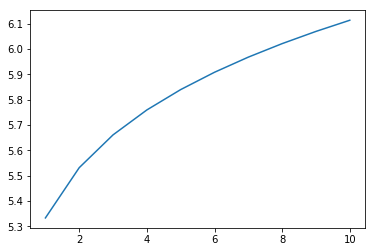

In [20]:
# Plot our yield curve to check that it is a realistic shape
plt.plot(years, yield_curve*100)
plt.show()

In [21]:
# Making use of bond pricing under Vasicek model to calibrate model 
#. Analytical bond price functions based off closed form Vasicek model
def A_t_T(t1,t2,alpha):
    return (1 - np.exp(-alpha*(t2-t1)))/alpha

def D_t_T(t1,t2,alpha,b,sigma):
    val1 = (sigma**2/(2*alpha**2)-b)*(-A_t_T(t1,t2,alpha)+ t2-t1)
    val2 = sigma**2*A_t_T(t1,t2,alpha)**2/(4*alpha)
    return val1-val2
    
def bond_price(r_t,t,T,alpha, b, sigma):
    return np.exp(-A_t_T(t,T,alpha)*r_t + D_t_T(t,T,alpha,b,sigma))

# Perform least absolute difference minimization
def F(array_estimates):
    alpha = array_estimates[0]
    b     = array_estimates[1]
    sigma = array_estimates[2]
    return  sum(np.abs(bond_price(r_0,0,years,alpha, b, sigma)- market_bond_prices))

In [29]:
#. Constraints and model requirements e.g Vasicek assumes parameters are postive
#   0<alpha<1, 0<b<0.2 , 0<sigma<0.2 upper bounds based on rationality check e.g data has highest yiled of 36% ,50% is ideal
bounds = ((0,2),(0,0.2),(0,0.2))

#. Use optimization function to find parameter values 
optimal_values = optimize.fmin_slsqp(F,(0.7,0.01,0.01),bounds=bounds)

# Use parameters from calibration to find model prices
model_bond_prices = bond_price(r_0,0,years,optimal_values[0],optimal_values[1],optimal_values[2])
model_yield_curve = np.log(model_bond_prices)/-years

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005119103487010945
            Iterations: 16
            Function evaluations: 106
            Gradient evaluations: 16


C:\Users\Zed\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Zed\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


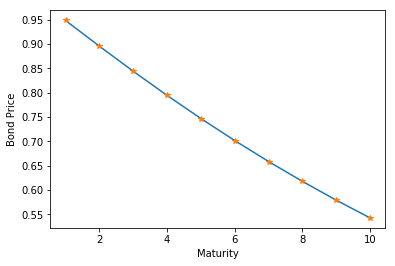

In [30]:
# Plot implied bond price curve against the market bond price curve
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(years, market_bond_prices)
plt.plot(years,model_bond_prices,'*')

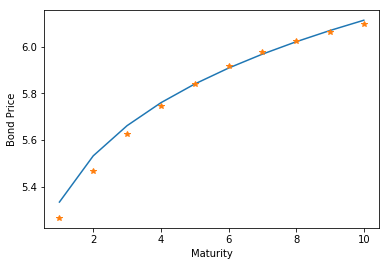

In [31]:
# Plot implied yield curve against the market yield curve
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(years, yield_curve*100)
plt.plot(years,model_yield_curve*100,'*')